### Load libraries

In [1]:
import sys
sys.path.insert(0, '/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [2]:
months = 12

date_start = str((dt.datetime.now() - pd.DateOffset(months = months)).date())
now = str(dt.datetime.now().date())

one_year_ago = str((pd.to_datetime(now) - pd.DateOffset(years = 1)).date())

print('Data is between %s and %s, which is the most recent %i months.' % (date_start, now, months))

Data is between 2018-05-10 and 2019-05-10, which is the most recent 12 months.


### Get back in stock notification data

In [38]:
back_main = pd.read_sql(
'''
SELECT
DATE(b.date_subscribed) AS date_subscribed,
DATE(b.date_sent) AS date_sent,
DATE(b.date_bought) AS date_bought,

# a customer can use their ID or their email to set a notification
# i left join on ID
# if the back_in_stock_notification_subscriptions.email is null, there is an ID and a corresponding email from customers.email
# in other words, if back_in_stock_notification_subscriptions.email is null, customers.email will not be null
LOWER(IFNULL(b.email_address, c.customers_email_address)) AS email,

b.customers_id,
b.part_id,
LOWER(pd.products_name) AS products_name
FROM bisns_logs b
LEFT JOIN customers c ON b.customers_id = c.customers_id
LEFT JOIN products_description pd ON b.part_id = pd.part_id
WHERE DATE(b.date_subscribed) >= ' '''+ date_start +''' '
''', db)

col_fix(back_main)

# change to datetime
for col in ['subscribed','sent','bought']:
        back_main['date %s' % col] = pd.to_datetime(back_main['date %s' % col], errors = 'coerce')
        
# find and remove where emails are null        
n = back_main[back_main['email'].isnull()]
if len(n) < 5:
    back_main.dropna(subset = ['email'], inplace = True)
    back_main.reset_index(drop = True, inplace = True)
else:
    display(n.head())
    raise ValueError('more than %i emails are nulls' % len(n))

# fill in dates where no subscriptions ocurred
dr = pd.date_range(date_start, now)
df = pd.DataFrame(columns = ['date'], data = dr)
df['date'] = pd.to_datetime(df['date'])

back_main = pd.merge(df, back_main, left_on = 'date', right_on = 'date subscribed', how = 'left')

# remove where part id is zeroif the proportion makes up less than 1% of all rows
zeros = back_main[back_main['part id'] == 0]

if len(zeros)/len(back_main) < 0.01: 
    back_main.drop(back_main[back_main['part id'] == 0].index, inplace = True)
    back_main.reset_index(drop = True, inplace = True)
else:
    display(zeros.head())
    raise ValueError('check where part_id = zero')

### Groupby part id check out counts

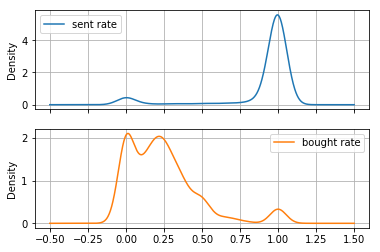

,Lower,Mean,Upper,Stand Dev,Sample Size
sent rate,88.7%,90.0%,91.2%,26.8%,"1,801"
bought rate,22.9%,24.0%,25.1%,23.6%,"1,693"


,bought rate
Count,"1,693"
Mean,24.0%
Std,23.6%
Min,0.0%
25%,5.0%
50%,20.0%
75%,33.3%
Max,100.0%


In [39]:
by_part = back_main.groupby(['part id','products name'], as_index = False)[['date subscribed','date sent','date bought']].count()
by_part.columns = by_part.columns.str.replace('date ','')

# get these rates
by_part['sent rate'] = by_part['sent']/by_part['subscribed']
by_part['bought rate'] = by_part['bought']/by_part['sent']

# remove where bought > sent
by_part.drop(by_part[by_part['bought'] > by_part['sent']].index, inplace = True)
by_part.reset_index(drop = True, inplace = True)

by_part[['sent rate','bought rate']].plot(subplots = True, kind = 'density', grid = True)
plt.show()

# get confidence intervals
fmt = ['p1'] * 4 + ['n0']
c = jb_conf(by_part[['sent rate','bought rate']]).T.format_(fmt)
display(c)

# describe it
fmt = ['n0'] + ['p1'] * 7
pd.DataFrame(by_part['bought rate'].describe()).T.format_(fmt).T

### Check out z-scores to get probability

In [40]:
import scipy.stats as st

alpha = 0.05
# one sided, scipy.stats.norm.ppf is not by default two-sided
probit = st.norm.ppf((1 - alpha))

m = by_part['bought rate'].mean()
s = by_part['bought rate'].std()

# this is P(X <= x) = 0.95
# -> P(Z <= (x-mu)/s) = P(X <= 0.95)
# -> P(Z <= (x-mu)/s) = 1.64
# -> x = (1.64*s) + mu

val = (probit * s) + m

print('There is a {:,.0f}% chance that any "bought rate" will exceed {:,.1f}%.'.format((alpha) * 100, val * 100))

There is a 5% chance that any "bought rate" will exceed 62.9%.


### Get top ten parts with highest sell-through rate

In [47]:
# drop where we didn't send anything or where no one bought anything
top = by_part.dropna().copy()

# some "bought rates" are 100%, but we sent x2 and x2 were bought
# this isn't very helpful
# so here we first take the top 5% by qty bought

q = 0.95
p = top['bought'].quantile(q)

# bottom us anything below p
bottom = top[top['bought'] <= p]

# and the top is everything above it
top.drop(bottom.index, inplace = True)
top.reset_index(drop = True, inplace = True)

In [51]:
fmt = [0,0,'n0','n0','n0','p1','p1']
top.sort_values('bought rate', ascending = False).head(10).format_(fmt)

,Part Id,Products Name,Subscribed,Sent,Bought,Sent Rate,Bought Rate
34,3343,adafruit crickit featherwing for any feather,140,140,69,100.0%,49.3%
23,2830,stacking headers for feather - 12-pin and 16-pin female headers,91,90,40,98.9%,44.4%
66,3964,adafruit veml6075 uva uvb and uv index sensor breakout,67,66,29,98.5%,43.9%
54,3857,adafruit feather m4 express - featuring atsamd51,"1,248","1,228",513,98.4%,41.8%
41,3500,adafruit trinket m0 - for use with circuitpython & arduino ide,405,402,167,99.3%,41.5%
15,2124,adafruit liion/lipoly backpack add-on for pro trinket/itsybitsy,108,108,44,100.0%,40.7%
70,4013,clear acrylic lens holder + hardware kit for hallowing,107,103,41,96.3%,39.8%
20,2348,adafruit dc & stepper motor hat for raspberry pi - mini kit,71,71,28,100.0%,39.4%
21,2590,adafruit metro mini 328 - arduino-compatible - 5v 16mhz,113,113,43,100.0%,38.1%
56,3900,adafruit hallowing m0 express,"1,704","1,703",644,99.9%,37.8%


In [57]:
print('done')

done
